In [1]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

import os

# https://youtu.be/hraKTseOuJA

"""
Dataset from here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html
"""


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from PIL import Image
import requests
import shutil
import urllib
import math


#Now let us read metadata to get our Y values (multiple lables)
os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv('data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)

styles = ["Symbolism", "Expressionism", "Impressionism" ,"Surrealism", "Baroque", "Neoclassicism", "Romanticism", "Realism"]


df = df[df["Style"].isin(styles)]
print(df.iloc[:20])

print(df.shape)

print(df.loc[df["Style"]=="Neoclassicism"])


#save images
main_dir = os.getcwd()
image_directory = os.getcwd()+"/data/img"#/new"
os.chdir(image_directory)

""" Test for a single image
img_url = "https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg"
img = Image.open(requests.get(img_url, stream = True).raw)
img = img.resize((300,300))
img.save("bla.jpg")
"""
"""
for index, row in df.iterrows():
    if not os.path.exists(str(index) + ".jpg"):
        img = Image.open(requests.get(row["Link"], stream=True).raw)
        img = img.resize((300, 300))
        img.convert("RGB").save(str(index) + ".jpg")
"""

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
         Style                           

'\nfor index, row in df.iterrows():\n    if not os.path.exists(str(index) + ".jpg"):\n        img = Image.open(requests.get(row["Link"], stream=True).raw)\n        img = img.resize((300, 300))\n        img.convert("RGB").save(str(index) + ".jpg")\n'

In [2]:

df = df[df.Date.str.isnumeric()] # only accept numeric dates
df["Date"] = pd.to_numeric(df["Date"])
df = df[df["Date"]>=1000]
#timedelta = 10
#timesteps = range(1000, 2020, 10)

# bring style to correct format
"""
for style in styles:
    df[style] = 0 #1 if (df["Style"]==style) else 0
    df.loc[df["Style"]==style, style] = 1
"""

# split into decades / other defined timedelta

# exact year to decade
df["Date"] = df["Date"].apply(lambda x: (math.floor(x/10))*10)

df=pd.get_dummies(df, columns=["Style", "Date"])

"""
for time in timesteps:
    df[str(time)+"s"]=0
"""

"""
for index, row in df.iterrows():
    found = False
    for time in timesteps:
        if math.floor((row["Date"]/10)*10) == time:
            row[str(time)+"s"] = 1
"""

'\nfor index, row in df.iterrows():\n    found = False\n    for time in timesteps:\n        if math.floor((row["Date"]/10)*10) == time:\n            row[str(time)+"s"] = 1\n'

In [3]:

SIZE = 200
X_dataset = []
#for i in tqdm(range(df.shape[0])):
for index, row in df.iterrows():
    img = image.image_utils.load_img(image_directory + "/" + str(index) + '.jpg', target_size=(SIZE,SIZE,3))
    img = image.image_utils.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    #df.loc[index,str(row["Date"])+"s"]=1 # to_categorical would have been the easy solution


X = np.array(X_dataset)

In [4]:


#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
#y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))
y = np.array(df.drop(['Artwork', 'Artist', 'Link'], axis=1))

print(len(X))
print(len(y))


22675
22675


In [5]:
import tensorflow as tf

os.chdir(main_dir+"/models")
csv_logger = tf.keras.callbacks.CSVLogger(os.getcwd()+"/log.csv", separator=",", append=True)
decades = [col for col in df if col.startswith("Date_")]
print(decades)

['Date_1580', 'Date_1590', 'Date_1600', 'Date_1610', 'Date_1620', 'Date_1630', 'Date_1640', 'Date_1730', 'Date_1740', 'Date_1750', 'Date_1760', 'Date_1770', 'Date_1780', 'Date_1790', 'Date_1800', 'Date_1810', 'Date_1820', 'Date_1830', 'Date_1840', 'Date_1850', 'Date_1860', 'Date_1870', 'Date_1880', 'Date_1890', 'Date_1900', 'Date_1910', 'Date_1920', 'Date_1930', 'Date_1940', 'Date_1950']


In [6]:

newModel = True
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

if newModel:
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    #Do not use softmax for multilabel classification
    #Softmax is useful for mutually exclusive classes, either cat or dog but not both.
    #Also, softmax outputs all add to 1. So good for multi class problems where each
    #class is given a probability and all add to 1. Highest one wins.

    #Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
    #like multi label, in this example.
    #But, also good for binary mutually exclusive (cat or not cat).

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64, callbacks=[csv_logger])

    # save model
    !mkdir -p saved_model
    model.save('saved_model/my_model_with_years')

else:
    model = keras.models.load_model('saved_model/my_model_with_years')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 196, 196, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0

2022-12-22 12:59:05.836135: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


248/248 [==============================] - 207s 830ms/step - loss: 0.3043 - accuracy: 0.0845 - val_loss: 0.1882 - val_accuracy: 0.0695
Epoch 2/5
248/248 [==============================] - 207s 833ms/step - loss: 0.2113 - accuracy: 0.1519 - val_loss: 0.1818 - val_accuracy: 0.2183
Epoch 3/5
248/248 [==============================] - 202s 813ms/step - loss: 0.1979 - accuracy: 0.1896 - val_loss: 0.1793 - val_accuracy: 0.2286
Epoch 4/5
248/248 [==============================] - 195s 787ms/step - loss: 0.1907 - accuracy: 0.2256 - val_loss: 0.1772 - val_accuracy: 0.2702
Epoch 5/5
248/248 [==============================] - 202s 814ms/step - loss: 0.1851 - accuracy: 0.2527 - val_loss: 0.1719 - val_accuracy: 0.2781


INFO:tensorflow:Assets written to: saved_model/my_model_with_years/assets


INFO:tensorflow:Assets written to: saved_model/my_model_with_years/assets


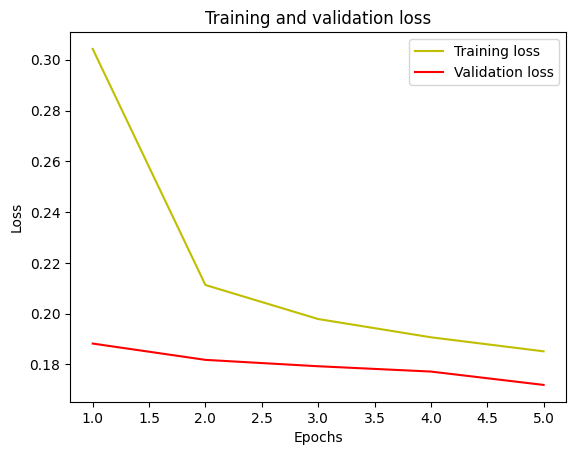

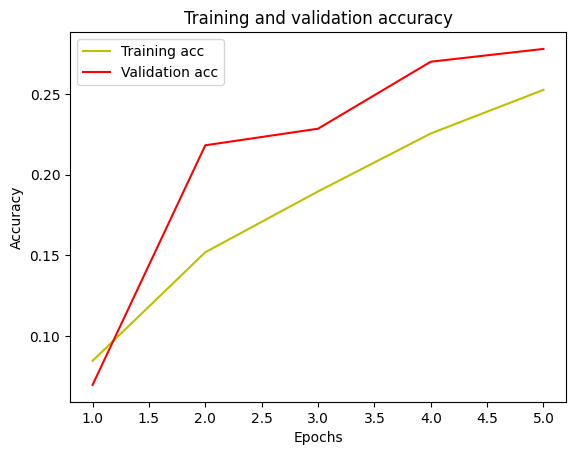

In [7]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 90ms/step
Date_1590 (0.2)
Style_Realism (0.177)
Date_1580 (0.156)
Style_Neoclassicism (0.138)
Date_1930 (0.135)
Style_Surrealism (0.134)
Style_Symbolism (0.129)
Date_1890 (0.129)
Style_Impressionism (0.097)
Date_1900 (0.0876)


'\n'

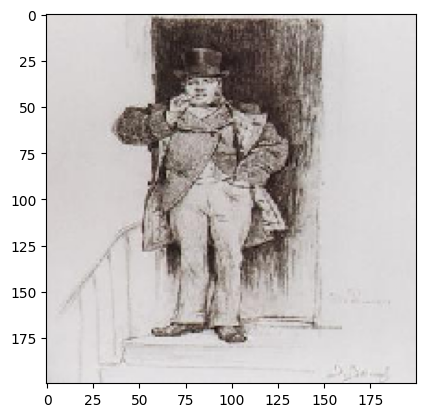

In [9]:
#################################################
#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
os.chdir(image_directory)
image_idx = 36300
img = image.image_utils.load_img(str(image_idx)+'.jpg', target_size=(SIZE,SIZE,3))

img = image.image_utils.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[5:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(10):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

###################################################

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

################################################################

"""
"""





In [10]:
print(df.loc[image_idx,:])

Artwork                                                     From Dominik
Artist                                                  Viktor Vasnetsov
Link                   https://uploads4.wikiart.org/images/viktor-vas...
Style_Baroque                                                          0
Style_Expressionism                                                    0
Style_Impressionism                                                    0
Style_Neoclassicism                                                    0
Style_Realism                                                          1
Style_Romanticism                                                      0
Style_Surrealism                                                       0
Style_Symbolism                                                        0
Date_1580                                                              0
Date_1590                                                              0
Date_1600                                          

In [0]:
# COnfusion Matrix
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1),test_predictions.argmax(axis=1))
print(cm)

[Text(0, 0.5, 'Style_Baroque'),
 Text(0, 1.5, 'Style_Expressionism'),
 Text(0, 2.5, 'Style_Impressionism'),
 Text(0, 3.5, 'Style_Neoclassicism'),
 Text(0, 4.5, 'Style_Realism'),
 Text(0, 5.5, 'Style_Romanticism'),
 Text(0, 6.5, 'Style_Surrealism'),
 Text(0, 7.5, 'Style_Symbolism')]

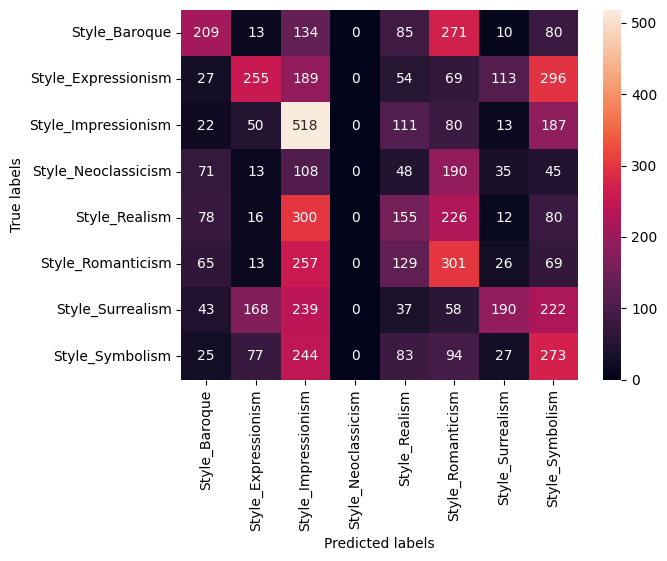

In [30]:
import seaborn as sns
cm = confusion_matrix(y_test[:,:9].argmax(axis=1),test_predictions[:,:9].argmax(axis=1))

ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
style_labels = ["Style_Baroque", "Style_Expressionism", "Style_Impressionism", "Style_Neoclassicism",
    "Style_Realism", "Style_Romanticism", "Style_Surrealism", "Style_Symbolism"]
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(style_labels); ax.yaxis.set_ticklabels(style_labels)

In [13]:
df[["Style_Baroque", "Style_Expressionism", "Style_Impressionism", "Style_Neoclassicism",
    "Style_Realism", "Style_Romanticism", "Style_Surrealism", "Style_Symbolism"]].apply(pd.Series.value_counts)

,Style_Baroque,Style_Expressionism,Style_Impressionism,Style_Neoclassicism,Style_Realism,Style_Romanticism,Style_Surrealism,Style_Symbolism
0,20070,19276,19424,21029,19816,19719,19526,19865
1,2605,3399,3251,1646,2859,2956,3149,2810


In [24]:
print(len(test_predictions))
print(len(test_predictions[0]))
print(test_predictions)
print(len(y_test))
print(len(y_test[0]))


6803
38
[[0.30473137 0.02010852 0.05297523 ... 0.01086463 0.00547059 0.00313209]
 [0.09110835 0.06305759 0.1833833  ... 0.02054127 0.01208328 0.00270327]
 [0.08890735 0.12183788 0.18440631 ... 0.04766944 0.0465238  0.01180001]
 ...
 [0.06196587 0.26604235 0.24941391 ... 0.09413464 0.1063612  0.01546887]
 [0.14528106 0.04334448 0.14716962 ... 0.02081735 0.0117775  0.00587346]
 [0.16079178 0.04707593 0.12177251 ... 0.01569047 0.00816021 0.00246575]]
6803
38
